<a href="https://colab.research.google.com/github/juhumkwon/Data/blob/main/07_Autoencoder(%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97       400
     Anomaly       0.50      1.00      0.67        20

    accuracy                           0.95       420
   macro avg       0.75      0.97      0.82       420
weighted avg       0.98      0.95      0.96       420



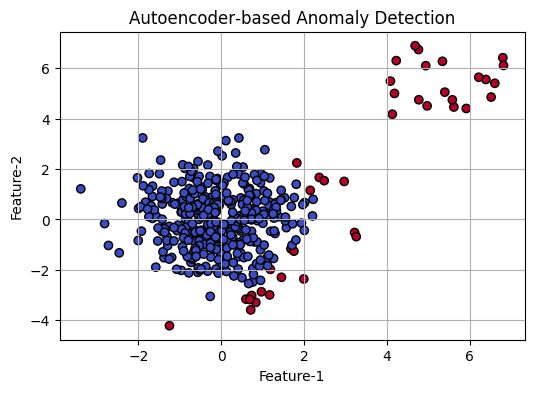

In [1]:
"""
Autoencoder‑based Anomaly Detection (toy example)
-------------------------------------------------
1) 2차원 정상 데이터를 생성 (이변량 정규분포)
2) 정상 데이터만으로 오토인코더 학습
3) 재구성 오차를 기준으로 이상치 판별
"""

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1. 데이터 만들기 ──────────────────────────────────────────
#   정상 400개  (가우시안)  |  이상치 20개 (범위 밖 랜덤)
normal = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[1, 0], [0, 1.5]],
    size=400
)

anomalies = np.random.uniform(low=[4, 4], high=[7, 7], size=(20, 2))
X      = np.vstack([normal, anomalies])
y_true = np.hstack([np.zeros(len(normal)), np.ones(len(anomalies))])   # 0=정상, 1=이상

# 2. 스케일링 (평균 0, 분산 1) ─────────────────────────────
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train  = X_scaled[y_true == 0]         # 오토인코더는 ‘정상’만 학습

# 3. 오토인코더 구성 & 학습 ────────────────────────────────
tf.keras.backend.clear_session()
input_dim = X_train.shape[1]

autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),   # bottleneck
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train,
                epochs=50, batch_size=32, verbose=0)

# 4. 재구성 오차로 이상치 판별 ─────────────────────────────
recon = autoencoder.predict(X_scaled)
mse   = np.mean(np.square(X_scaled - recon), axis=1)

threshold = np.percentile(mse[y_true == 0], 95)   # 정상 중 95% 지점
y_pred = (mse > threshold).astype(int)

print(classification_report(y_true, y_pred, target_names=['Normal','Anomaly']))

# 5. 시각화 (옵션) ─────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='coolwarm', edgecolors='k')
plt.title("Autoencoder‑based Anomaly Detection")
plt.xlabel("Feature‑1"); plt.ylabel("Feature‑2")
plt.grid(True); plt.show()
